<a href="https://colab.research.google.com/github/oganiler/google_colab/blob/main/Transfer_Learning_(VGG16)_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2026-02-23 21:44:00--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dn721600.ca.archive.org/0/items/food-5-k/Food-5K.zip [following]
--2026-02-23 21:44:01--  https://dn721600.ca.archive.org/0/items/food-5-k/Food-5K.zip
Resolving dn721600.ca.archive.org (dn721600.ca.archive.org)... 204.62.247.19
Connecting to dn721600.ca.archive.org (dn721600.ca.archive.org)|204.62.247.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  3.39MB/s    in 53s     

2026-02-23 21:44:55 (7.98 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
#unzip the data to use
!unzip -qq -o Food-5K.zip
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [5]:
!ls Food-5K

evaluation  training  validation


In [6]:
#we need seperate folder of each class for tensorflow
#in this dataset we have 2 classes (food (1_xxxx.jpg) and "not-food (0_xxxx.jpg)")

#first let's move everything to the current directory
!mv Food-5K/* .

In [9]:
!mkdir data

# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [16]:
train_path = 'data/train'
valid_path = 'data/test'

# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [224, 224]

#in case we use keras Image Generator (depraceted, we will use keras tfdata)
# useful for getting number of files
# image_files = glob(train_path + '/*/*.jpg')
# valid_image_files = glob(valid_path + '/*/*.jpg')

# useful for getting number of classes
# folders = glob(train_path + '/*')
# folders

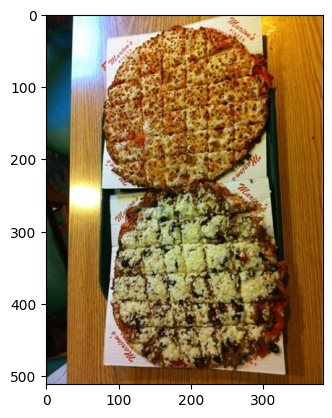

In [15]:
# look at an image for fun
plt.imshow(image.load_img('data/train/food/1_616.jpg'))
plt.show()

In [17]:
batch_size = 128
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [18]:
# check the class names
class_names = train_ds.class_names
K = len(class_names)
print(class_names)

['food', 'nonfood']


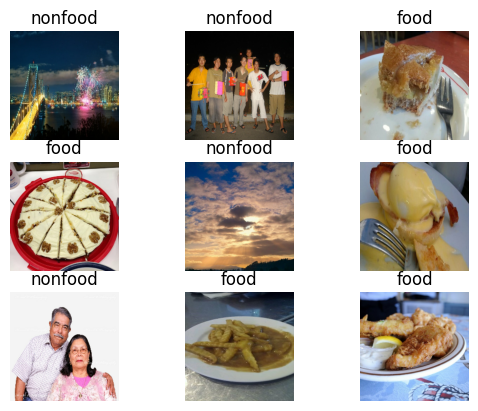

In [19]:
# visualize the data
for images, labels in train_ds.take(1):
  # takes one batch, but we'll only use 9 (3x3)
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
# size of data in each batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [35]:
#AUTOTUNE lets TensorFlow dynamically determine the optimal buffer size for parallelism and prefetching at runtime.
AUTOTUNE = tf.data.AUTOTUNE
#Instead of manually picking: prefetch(buffer_size=4)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
#vgg body
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [37]:
#let's freeze the vgg body weights
ptm.trainable = False

In [38]:
# data augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [39]:
# Build the model using the functional API
i = Input(shape=IMAGE_SIZE + [3])
x = preprocess_input(i)
x = data_augmentation(x)
x = ptm(x)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)
model = Model(inputs=i, outputs=x)

In [40]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ add_1[0][0]       │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │     50,178 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [41]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [34]:
# fit the model
r = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  #steps_per_epoch=len(train_ds) // batch_size, we do not need this, we are using datasets, already know
  #validation_steps=len(val_ds) // batch_size we do not need this, we are using datasets, already know
)

Epoch 1/10
 8/24 ━━━━━━━━━━━━━━━━━━━━ 20:51 78s/step - accuracy: 0.6567 - loss: 10.3223

KeyboardInterrupt: 

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()